# Script for Loading a PINN model and Comparing it to a COMSOL Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from UnNormalized_Plots import plot_losses, predict_and_plot, predict_and_quiver, plot_residuals, print_boundary_summary, plot_velocity_profiles, validation_by_flux, predict_and_plot_on_collocation
from Training_Montage import get_unique_run_folder, save_figure, make_video
from The_Reporter import write_report, save_outputs
from PINN_Functions import domain, normalize_domain_outputs, build_mlp, xavier_initialization, PINN, PINN_branched

Load the COMSOL export file

In [2]:
# Path to COMSOL text file
filepath = 'Re_20-U_010.txt'  

# Read the file while skipping metadata lines (starting with '%')
df = pd.read_csv(
    filepath,
    sep='\s+',
    comment='%',
    header=None,
)

df.columns = ['x', 'y', 'u', 'v', 'p']

# Preview the data
print(df.head())

# access each variable:
x = df['x'].values
y = df['y'].values
u = df['u'].values
v = df['v'].values
p = df['p'].values

          x         y         u         v         p
0  0.001729 -0.197938  0.020492  0.000013  6.075981
1  0.000000 -0.198760  0.012362  0.000000  6.080059
2  0.002681 -0.198758  0.012366  0.000007  6.072937
3  0.000000 -0.197646  0.023397  0.000000  6.079799
4  0.006704 -0.197755  0.022213  0.000022  6.065370


Plot if desired

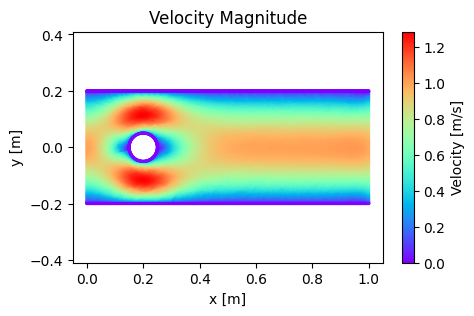

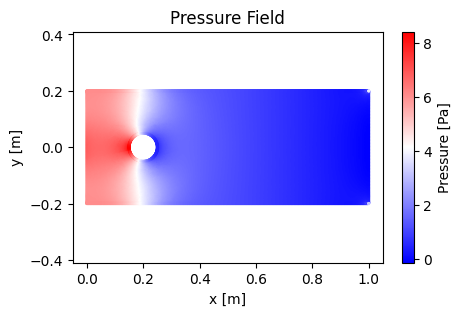

In [3]:
# Compute velocity magnitude
velocity_magnitude = np.sqrt(u**2 + v**2)

# Plot settings
def plot_scalar_field(x, y, values, title, cmap='bwr', colorbar_label='', filename=None):
    plt.figure(figsize=(5, 3))
    sc = plt.scatter(x, y, c=values, cmap=cmap, s=5, edgecolor='none')
    plt.colorbar(sc, label=colorbar_label)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title(title)
    plt.axis('equal')
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# # Plot u-component
# plot_scalar_field(x, y, u, title='Velocity Component u (x-direction)', cmap='rainbow', colorbar_label='u [m/s]')

# # Plot v-component
# plot_scalar_field(x, y, v, title='Velocity Component v (y-direction)', cmap='rainbow', colorbar_label='v [m/s]')

# Plot velocity magnitude
plot_scalar_field(x, y, velocity_magnitude, title='Velocity Magnitude', cmap='rainbow', colorbar_label='Velocity [m/s]')

# Plot pressure
plot_scalar_field(x, y, p, title='Pressure Field', cmap='bwr', colorbar_label='Pressure [Pa]')


Load the PINN model

In [4]:
# ---------- CONFIG ----------
# Change these to match your run
checkpoint_path = "compare7.pth"  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

shared_layers = [2, 60, 60, 60, 60, 60, 60, 60, 60, 60, 3]
velocity_layers = [2]
pressure_layers = [1]
activation = nn.Tanh()
use_xavier = True
N_walls=1000
N_inlet=200
N_outlet=200
N_cylinder=400
N_collocation=49152
L_total=1.0
pipe_radius=0.2
cylinder_radius=0.05
cylinder_center=(0.2, 0.0)
margin=0.01
sections = [
    ("Pipe", 0, 1.0)
]

domain_outputs = domain(N_walls=N_walls,
                                N_inlet=N_inlet,
                                N_outlet=N_outlet,
                                N_cylinder=N_cylinder,
                                N_collocation=N_collocation,
                                L_total=L_total,
                                pipe_radius=pipe_radius,
                                cylinder_radius=cylinder_radius,
                                cylinder_center=cylinder_center,
                                margin=margin)
    
x_y_top, x_y_bottom, x_y_inlet, x_y_outlet, x_y_cylinder, x_y_collocation, h_total, x_vals_total = domain_outputs

x_y_top_norm, x_y_bottom_norm, x_y_inlet_norm, x_y_outlet_norm, x_y_cylinder_norm, x_y_collocation_norm, \
    _, _, scale_factor = normalize_domain_outputs(domain_outputs, L_total, pipe_radius, cylinder_center, cylinder_radius)

h_total_norm = h_total * scale_factor
x_vals_total_norm = (x_vals_total - L_total / 2.0) * scale_factor

# Move to device
x_y_top = x_y_top.to(device)
x_y_bottom = x_y_bottom.to(device)
x_y_inlet = x_y_inlet.to(device)
x_y_outlet = x_y_outlet.to(device)
x_y_cylinder = x_y_cylinder.to(device)
x_y_collocation = x_y_collocation.to(device)
x_y_top_norm = x_y_top_norm.to(device)
x_y_bottom_norm = x_y_bottom_norm.to(device)
x_y_inlet_norm = x_y_inlet_norm.to(device)
x_y_outlet_norm = x_y_outlet_norm.to(device)
x_y_cylinder_norm = x_y_cylinder_norm.to(device)
x_y_collocation_norm = x_y_collocation_norm.to(device)

model = PINN(shared_layers, activation, use_xavier).to(device)

# ---------- LOAD CHECKPOINT ----------
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\nv1n24\AppData\Local\Temp\ipykernel_15152\860313799.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

PINN(
  (shared): Sequential(
    (0): Linear(in_features=2, out_features=60, bias=True)
    (1): Tanh()
    (2): Linear(in_features=60, out_features=60, bias=True)
    (3): Tanh()
    (4): Linear(in_features=60, out_features=60, bias=True)
    (5): Tanh()
    (6): Linear(in_features=60, out_features=60, bias=True)
    (7): Tanh()
    (8): Linear(in_features=60, out_features=60, bias=True)
    (9): Tanh()
    (10): Linear(in_features=60, out_features=60, bias=True)
    (11): Tanh()
    (12): Linear(in_features=60, out_features=60, bias=True)
    (13): Tanh()
    (14): Linear(in_features=60, out_features=60, bias=True)
    (15): Tanh()
    (16): Linear(in_features=60, out_features=60, bias=True)
    (17): Tanh()
    (18): Linear(in_features=60, out_features=3, bias=True)
  )
)

c:\Users\nv1n24\OneDrive - University of Southampton\PhD\Research\PINNs Code\Functions\UnNormalized_Plots.py:114: UserWarning: Adding colorbar to a different Figure <Figure size 700x300 with 2 Axes> than <Figure size 700x300 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(all_contours_v[0], ax=ax1, label="Velocity Magnitude [m/s]")


(<Figure size 700x300 with 2 Axes>, <Figure size 700x300 with 2 Axes>)

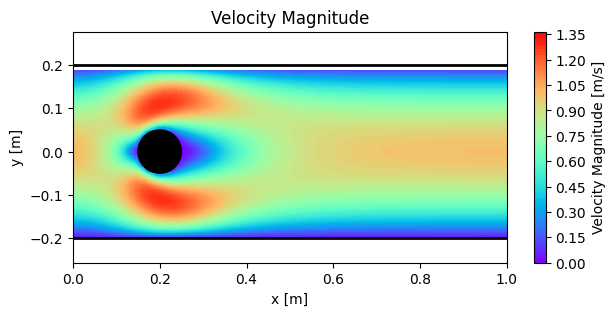

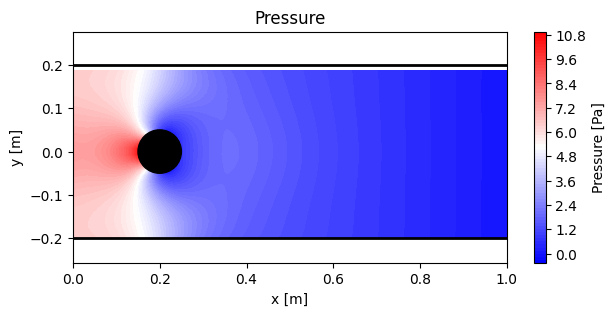

In [5]:
predict_and_plot(model, device, sections, x_vals_total, h_total, 
                            L_total, scale_factor, cylinder_center, cylinder_radius,  
                            fig_sizes=(7,3), ymin=-0.6, ymax=0.6, y_density=100, grid_onoff=False)

Get PINN results at the same points as COMSOL has

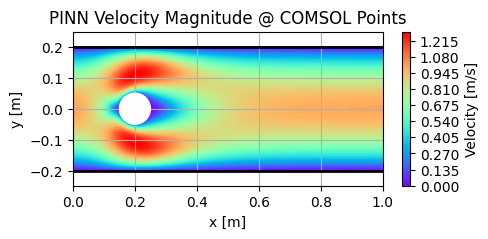

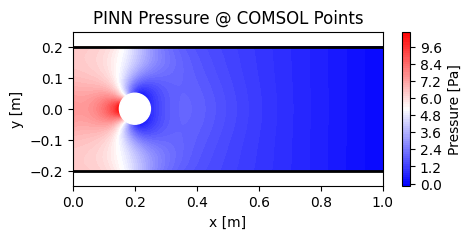

In [6]:
def predict_at_comsol_points(model, device, df, x_vals_total, h_total, L_total, pipe_radius,
                             cylinder_center, cylinder_radius, scale_factor):
    """
    Predicts u, v, p using the normalized PINN at COMSOL data points, plots the results, and returns values.
    
    Args:
        model (torch.nn.Module): Trained PINN model.
        device (torch.device): CPU or GPU.
        df (pd.DataFrame): COMSOL data with columns ['x', 'y'] at which to evaluate.
        x_vals_total (np.ndarray): x values for nozzle wall profile.
        h_total (np.ndarray): nozzle half-height profile.
        L_total (float): The original total length of the domain.
        pipe_radius (float): The original half-height of the pipe.
        cylinder_center (tuple): The original (x, y) coordinates of the cylinder center.
        cylinder_radius (float): The original radius of the cylinder.
        min_vel, max_vel: for velocity colorbar.
        min_pres, max_pres: for pressure colorbar.
    
    Returns:
        fig1, fig2: Matplotlib figures for velocity magnitude and pressure.
        x_valid, y_valid: Arrays of coordinates within the nozzle.
        u, v, p, vel_mag: Predicted values at those coordinates.
    """
    x_center = L_total / 2.0
    x_comsol = df['x'].values
    y_comsol = df['y'].values

    # Mask out points outside nozzle walls
    h_at_x = np.interp(x_comsol, x_vals_total, h_total)
    mask_walls = np.abs(y_comsol) <= h_at_x
    
    # Cylinder masking
    cylinder_x, cylinder_y = cylinder_center
    distance_from_center = np.sqrt((x_comsol - cylinder_x)**2 + (y_comsol - cylinder_y)**2)
    mask_cylinder = distance_from_center > cylinder_radius
    
    # Combine the masks to get valid points for model prediction and plotting
    combined_mask = mask_walls & mask_cylinder
    
    x_valid_unnorm = x_comsol[combined_mask]
    y_valid_unnorm = y_comsol[combined_mask]
    
    # Normalize the valid coordinates before feeding them to the model
    x_valid_norm = (x_valid_unnorm - x_center) * scale_factor
    y_valid_norm = y_valid_unnorm * scale_factor

    input_tensor = torch.tensor(np.stack([x_valid_norm, y_valid_norm], axis=1), dtype=torch.float32).to(device)
    with torch.no_grad():
        pred = model(input_tensor)
        u = pred[:, 0].cpu().numpy()
        v = pred[:, 1].cpu().numpy()
        p = pred[:, 2].cpu().numpy()
        vel_mag = np.sqrt(u**2 + v**2)/ scale_factor

    # Plot velocity magnitude
    fig1, ax1 = plt.subplots(figsize=(5, 2))
    contour_v = ax1.tricontourf(x_valid_unnorm, y_valid_unnorm, vel_mag, levels=100, cmap='rainbow')
    
    # Plot cylinder as a white circle on top
    cylinder_patch_v = plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2)
    ax1.add_patch(cylinder_patch_v)
    
    ax1.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax1.plot(x_vals_total, -h_total, 'k-', linewidth=2)
    ax1.set_title("PINN Velocity Magnitude @ COMSOL Points")
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")
    ax1.axis("equal")
    ax1.grid(True)
    plt.colorbar(contour_v, ax=ax1, label="Velocity [m/s]")
    
    # Plot pressure
    fig2, ax2 = plt.subplots(figsize=(5, 2))
    contour_p = ax2.tricontourf(x_valid_unnorm, y_valid_unnorm, p, levels=100, cmap='bwr')
    
    # Plot cylinder as a white circle on top
    cylinder_patch_p = plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2)
    ax2.add_patch(cylinder_patch_p)
    
    ax2.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax2.plot(x_vals_total, -h_total, 'k-', linewidth=2)
    ax2.set_title("PINN Pressure @ COMSOL Points")
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("y [m]")
    ax2.axis("equal")
    #ax2.grid(True)
    plt.colorbar(contour_p, ax=ax2, label="Pressure [Pa]")

    return fig1, fig2, x_valid_unnorm, y_valid_unnorm, u, v, p, vel_mag

# Assuming df is your COMSOL data frame and x_vals_total/h_total are unnormalized
fig1, fig2, x_pred, y_pred, u_pred, v_pred, p_pred, vel_mag_pred = predict_at_comsol_points(
    model, device, df, 
    x_vals_total, h_total,
    L_total, pipe_radius, cylinder_center, cylinder_radius, scale_factor
)

Compare the COMSOL and PINN outputs

RMSE for Velocity Magnitude: 0.0541
RMSE for Pressure: 0.3587
Average Percentage Error for Velocity Magnitude: 8.24%
Average Percentage Error for Pressure: 16.60%
Min and Max Values in the domain:
COMSOL vel_mag: min=0.000, max=1.286
PINN   vel_mag: min=0.000, max=1.290
COMSOL pressure: min=-0.144, max=8.427
PINN   pressure: min=-0.001, max=10.584


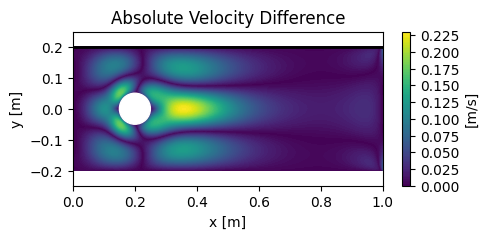

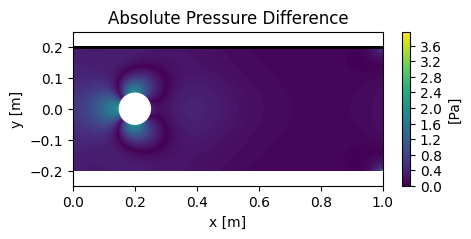

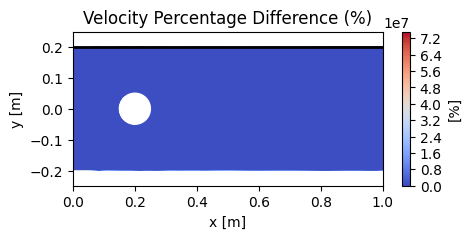

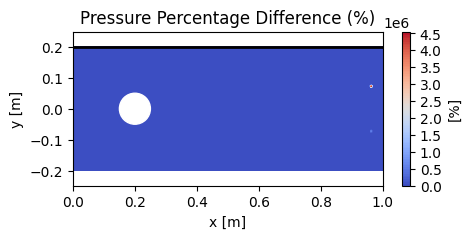

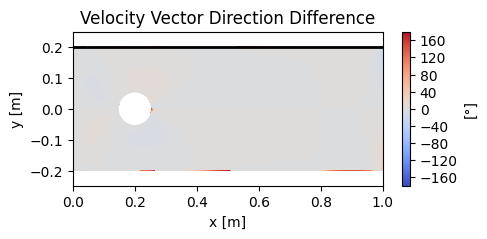

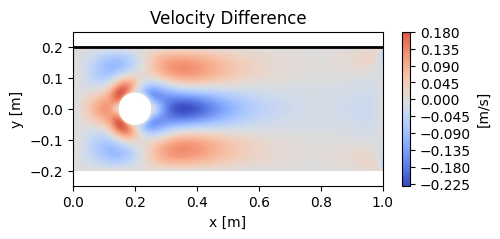

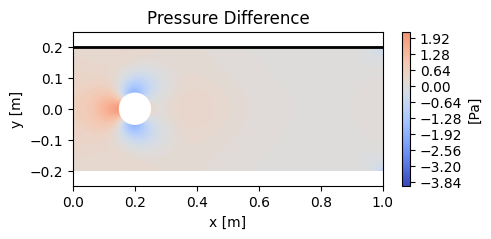

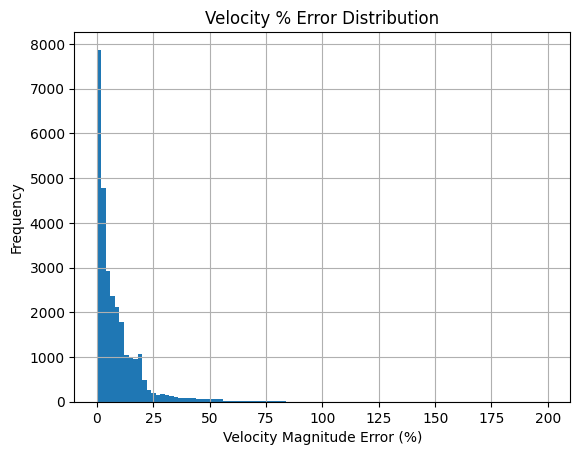

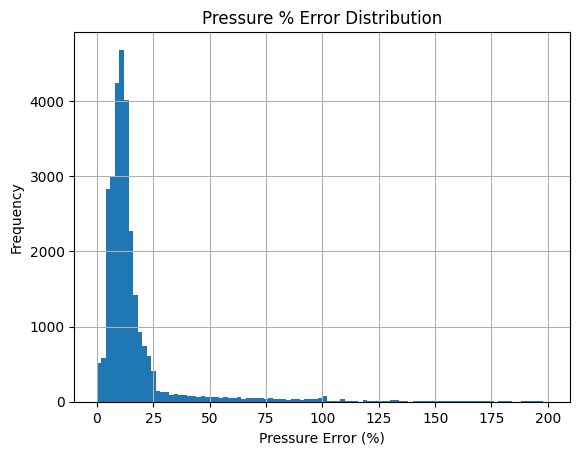

In [7]:
def compare_results(df_comsol, x_pred, y_pred, u_pred, v_pred, vel_mag_pred, p_pred,
                    x_vals_total, h_total, cylinder_center, cylinder_radius, threshold_vel=0.01, threshold_pres=0.01):
    """
    Compare PINN predictions with COMSOL results.
    Produces:
      1. Absolute velocity difference plot
      2. Absolute pressure difference plot
      3. Percentage velocity difference plot
      4. Percentage pressure difference plot
      5. Velocity vector direction difference plot
      6. Signed velocity difference plot
      7. Signed pressure difference plot
      8. Histograms of % errors (velocity & pressure)
      Prints min/max for sanity check.
    """
    # Create a DataFrame from the PINN prediction points
    df_pinn = pd.DataFrame({
        'x': x_pred,
        'y': y_pred,
        'u_pred': u_pred,
        'v_pred': v_pred,
        'vel_mag_pinn': vel_mag_pred,
        'p_pinn': p_pred
    })

    # Calculate COMSOL velocity magnitude
    df_comsol['vel_mag_comsol'] = np.sqrt(df_comsol['u']**2 + df_comsol['v']**2)

    # Merge the COMSOL and PINN DataFrames
    df_comparison = pd.merge(df_comsol, df_pinn, on=['x', 'y'], how='inner')

    # Extract COMSOL reference values
    vel_mag_true = df_comparison['vel_mag_comsol'].values
    p_true = df_comparison['p'].values
    u_true = df_comparison['u'].values
    v_true = df_comparison['v'].values

    # Predicted velocities
    u_pred = df_comparison['u_pred'].values
    v_pred = df_comparison['v_pred'].values

    # Calculate absolute differences
    vel_mag_diff = np.abs(df_comparison['vel_mag_pinn'] - df_comparison['vel_mag_comsol'])
    p_diff = np.abs(df_comparison['p_pinn'] - df_comparison['p'])

    # Calculate RMSE
    rmse_vel_mag = np.sqrt(np.mean(vel_mag_diff**2))
    rmse_p = np.sqrt(np.mean(p_diff**2))

    # Calculate average percentage errors with filtering
    valid_vel_mask = df_comparison['vel_mag_comsol'] > threshold_vel
    vel_mag_perc_diff = np.full(len(df_comparison), np.nan)
    vel_mag_perc_diff[valid_vel_mask] = (vel_mag_diff[valid_vel_mask] / 
                                        df_comparison['vel_mag_comsol'][valid_vel_mask]) * 100

    valid_p_mask = df_comparison['p'] > threshold_pres
    p_perc_diff = np.full(len(df_comparison), np.nan)
    p_perc_diff[valid_p_mask] = (p_diff[valid_p_mask] / 
                                df_comparison['p'][valid_p_mask]) * 100
    
    avg_perc_vel = np.nanmean(vel_mag_perc_diff)
    avg_perc_p = np.nanmean(p_perc_diff)

    print(f"RMSE for Velocity Magnitude: {rmse_vel_mag:.4f}")
    print(f"RMSE for Pressure: {rmse_p:.4f}")
    print(f"Average Percentage Error for Velocity Magnitude: {avg_perc_vel:.2f}%")
    print(f"Average Percentage Error for Pressure: {avg_perc_p:.2f}%")

    # === Existing: absolute differences ===
    vel_mag_abs_diff = np.abs(vel_mag_pred - vel_mag_true)
    p_abs_diff = np.abs(p_pred - p_true)

    # === Existing: percentage differences ===
    eps = 1e-8
    vel_mag_perc_diff = np.abs(vel_mag_pred - vel_mag_true) / np.maximum(np.abs(vel_mag_true), eps) * 100
    p_perc_diff = np.abs(p_pred - p_true) / np.maximum(np.abs(p_true), eps) * 100

    # === New: signed differences ===
    vel_mag_signed_diff = vel_mag_pred - vel_mag_true
    p_signed_diff = p_pred - p_true

    # === New: velocity vector direction difference ===
    theta_pred = np.arctan2(v_pred, u_pred)
    theta_true = np.arctan2(v_true, u_true)
    angle_diff = np.rad2deg(theta_pred - theta_true)
    angle_diff = (angle_diff + 180) % 360 - 180  # Normalize to [-180, 180]

    # === RMSE calculations ===
    rmse_vel_mag = np.sqrt(np.mean((vel_mag_pred - vel_mag_true) ** 2))
    rmse_p = np.sqrt(np.mean((p_pred - p_true) ** 2))
    avg_perc_vel = np.mean(vel_mag_perc_diff)
    avg_perc_p = np.mean(p_perc_diff)

    # === Min/max sanity check ===
    print(f"Min and Max Values in the domain:")
    print(f"COMSOL vel_mag: min={vel_mag_true.min():.3f}, max={vel_mag_true.max():.3f}")
    print(f"PINN   vel_mag: min={vel_mag_pred.min():.3f}, max={vel_mag_pred.max():.3f}")
    print(f"COMSOL pressure: min={p_true.min():.3f}, max={p_true.max():.3f}")
    print(f"PINN   pressure: min={p_pred.min():.3f}, max={p_pred.max():.3f}")

    # === 1. Absolute velocity difference ===
    fig1, ax1 = plt.subplots(figsize=(5, 2))
    c1 = ax1.tricontourf(df_comparison['x'], df_comparison['y'], vel_mag_abs_diff, levels=100, cmap='viridis')
    ax1.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax1.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax1.set_title("Absolute Velocity Difference")
    ax1.set_xlabel("x [m]")
    ax1.set_ylabel("y [m]")
    ax1.axis("equal")
    plt.colorbar(c1, ax=ax1, label="[m/s]")

    # === 2. Absolute pressure difference ===
    fig2, ax2 = plt.subplots(figsize=(5, 2))
    c2 = ax2.tricontourf(df_comparison['x'], df_comparison['y'], p_abs_diff, levels=100, cmap='viridis')
    ax2.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax2.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax2.set_title("Absolute Pressure Difference")
    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("y [m]")
    ax2.axis("equal")
    plt.colorbar(c2, ax=ax2, label="[Pa]")

    # === 3. Percentage velocity difference ===
    fig3, ax3 = plt.subplots(figsize=(5, 2))
    c3 = ax3.tricontourf(df_comparison['x'], df_comparison['y'], vel_mag_perc_diff, levels=100, cmap='coolwarm')
    ax3.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax3.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax3.set_title("Velocity Percentage Difference (%)")
    ax3.set_xlabel("x [m]")
    ax3.set_ylabel("y [m]")
    ax3.axis("equal")
    plt.colorbar(c3, ax=ax3, label="[%]")

    # === 4. Percentage pressure difference ===
    fig4, ax4 = plt.subplots(figsize=(5, 2))
    c4 = ax4.tricontourf(df_comparison['x'], df_comparison['y'], p_perc_diff, levels=100, cmap='coolwarm')
    ax4.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax4.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax4.set_title("Pressure Percentage Difference (%)")
    ax4.set_xlabel("x [m]")
    ax4.set_ylabel("y [m]")
    ax4.axis("equal")
    plt.colorbar(c4, ax=ax4, label="[%]")

    # === 5. Velocity vector direction difference ===
    fig5, ax5 = plt.subplots(figsize=(5, 2))
    c5 = ax5.tricontourf(df_comparison['x'], df_comparison['y'], angle_diff, levels=100, cmap='coolwarm')
    ax5.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax5.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax5.set_title("Velocity Vector Direction Difference")
    ax5.set_xlabel("x [m]")
    ax5.set_ylabel("y [m]")
    ax5.axis("equal")
    plt.colorbar(c5, ax=ax5,  label="[°]")

    # ===== Signed velocity magnitude difference =====
    fig5, ax5 = plt.subplots(figsize=(5, 2))
    max_abs_vel_diff = np.nanmax(np.abs(vel_mag_signed_diff))
    c5 = ax5.tricontourf(df_comparison['x'], df_comparison['y'], vel_mag_signed_diff,
                        levels=100, cmap='coolwarm',
                        vmin=-max_abs_vel_diff, vmax=max_abs_vel_diff)
    ax5.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax5.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax5.set_title("Velocity Difference")
    ax5.set_xlabel("x [m]")
    ax5.set_ylabel("y [m]")
    ax5.axis("equal")
    plt.colorbar(c5, ax=ax5, label="[m/s]")

    # ===== Signed pressure difference =====
    fig6, ax6 = plt.subplots(figsize=(5, 2))
    max_abs_p_diff = np.nanmax(np.abs(p_signed_diff))
    c6 = ax6.tricontourf(df_comparison['x'], df_comparison['y'], p_signed_diff,
                        levels=100, cmap='coolwarm',
                        vmin=-max_abs_p_diff, vmax=max_abs_p_diff)
    ax6.add_patch(plt.Circle(cylinder_center, cylinder_radius, color='white', zorder=2))
    ax6.plot(x_vals_total, h_total, 'k-', linewidth=2)
    ax6.set_title("Pressure Difference")
    ax6.set_xlabel("x [m]")
    ax6.set_ylabel("y [m]")
    ax6.axis("equal")
    plt.colorbar(c6, ax=ax6, label="[Pa]")


    # === 8. Histograms ===
    plt.figure()
    plt.hist(vel_mag_perc_diff, bins=100, range=(0, 200))
    plt.xlabel('Velocity Magnitude Error (%)')
    plt.ylabel('Frequency')
    plt.title('Velocity % Error Distribution')
    plt.grid(True)

    plt.figure()
    plt.hist(p_perc_diff, bins=100, range=(0, 200))
    plt.xlabel('Pressure Error (%)')
    plt.ylabel('Frequency')
    plt.title('Pressure % Error Distribution')
    plt.grid(True)

    return fig1, fig2, fig3, fig4, fig5, fig6, rmse_vel_mag, rmse_p, avg_perc_vel, avg_perc_p

fig1, fig2, fig3, fig4, fig5, fig6, rmse_vel_mag, rmse_p, avg_perc_vel, avg_perc_p = compare_results(df, 
                    x_pred, y_pred, u_pred, v_pred, vel_mag_pred, p_pred,
                    x_vals_total, h_total, cylinder_center, cylinder_radius, threshold_vel=0.01, threshold_pres=0.01)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


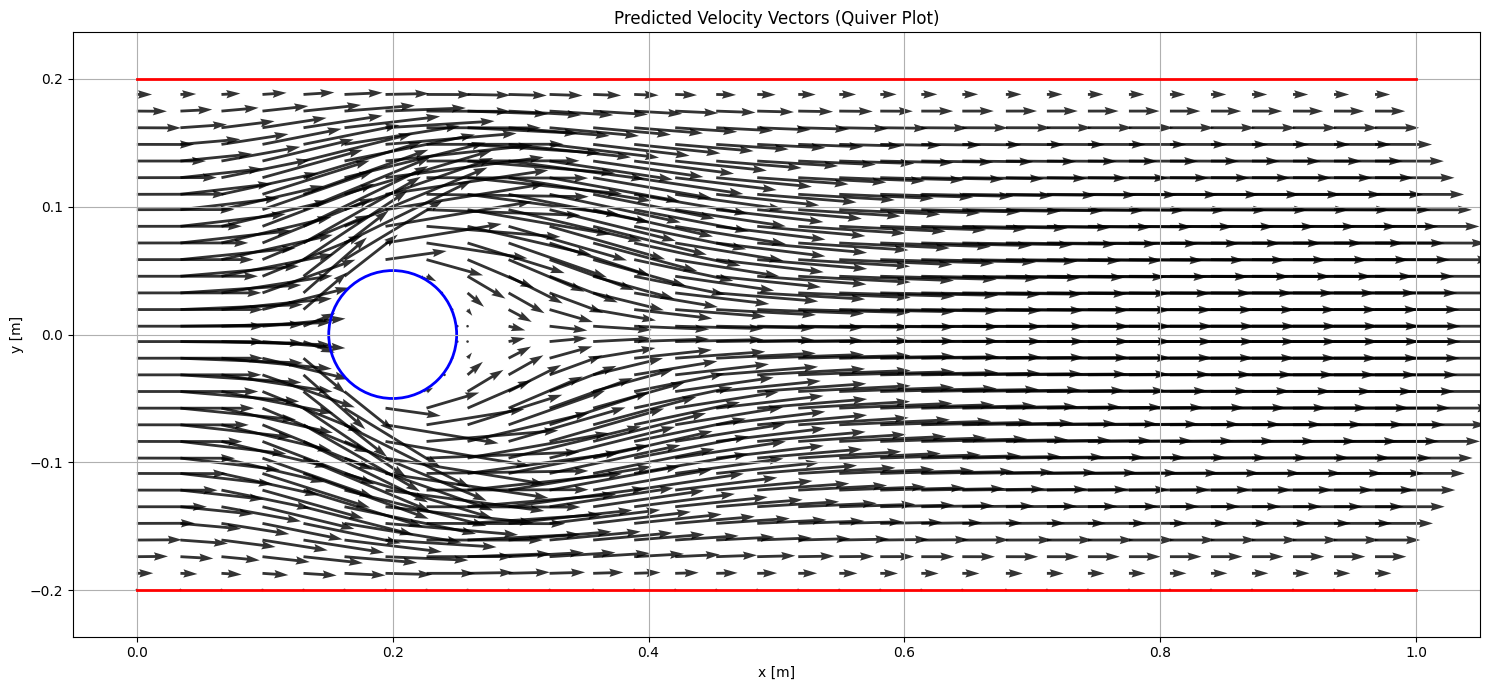

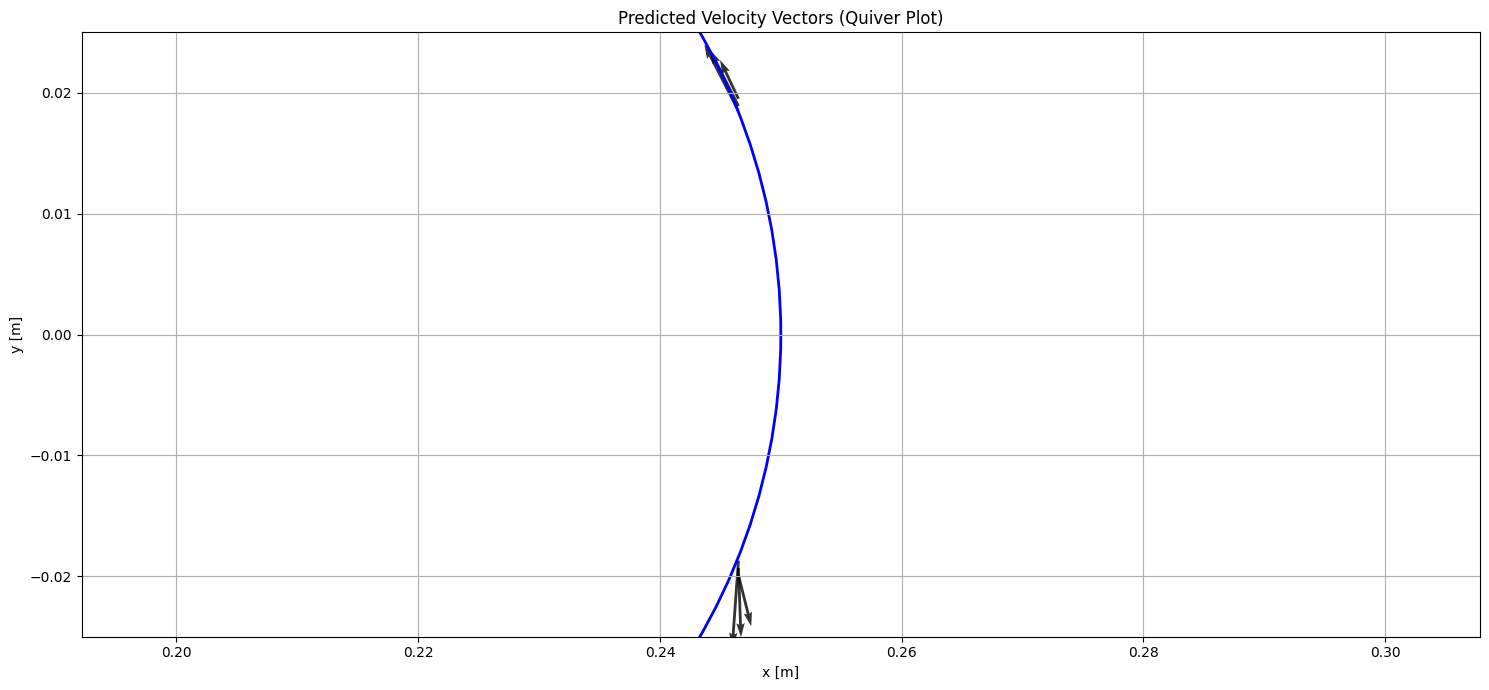

In [8]:
fig = predict_and_quiver(model, device, sections, scale_factor, L_total, x_vals_total, h_total, cylinder_center, cylinder_radius, 
                         density=1000, scale=10, xlim=None, ylim=None, ymin=-0.5, ymax=0.5, y_density=1000, isolate_region=None)

fig = predict_and_quiver(model, device, sections, scale_factor, L_total, x_vals_total, h_total, cylinder_center, cylinder_radius, 
                         density=5000, scale=1, xlim=(0.2,0.3), ylim=(-0.025,0.025), ymin=-0.5, ymax=0.5, y_density=5000, isolate_region=(0.2, 0.25, -0.02, 0.02))